In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

### Задание 3
**Срок сдачи: 04 апреля 21:00**

**Финальный срок сдачи с понижением балов до 50%: 09 апреля 21:00**

В этом задание вы будете работать с выручкой - метрикой с достаточно высокой дисперсией и соответсвенно низкой чувствительностью к изменениям.

Вам предстоит разработать подход по повышению чувствительности этой метрики.
От успеха данной инициативы зависит то, как быстро мы сможем проверять продуктовые гипотезы.

#### Для планирования эксперимента изучите данные и метрики 2 балла:

- Загрузите файл и изучите данные;
- Изучите основные статистики метрики: среднее, стандартное отклонение;
- Изучите то, как эти статистики изменяются внутри срезов: user_segment, region, category

#### Предскажите минимально детектируемый эффект (MDE) 2 балла:

- Для размеров тестовых групп 10,25,50% и длительностей 30, 60, 90 дней предскажите минимально детектируемый эффект;


#### CUPED 6 баллов
Разработайте подход по снижению дисперсии на основе методики CUPED:

- Рассчитайте CUPED метрику на основе данных за периода в 30 дней перед предполагаемым периодом сбора основной выборки и опишите как изменился MDE для выборок 50/50%, собранных за 30 дней (2 бала). 
- Проверьте насколько данный подход подвержен сезональности. Как меняется MDE, если применять данный подход в разные периоды (2 бала). 
- Оптимизируйте подход варьируя количество дней до теста, которые вы будете для расчёта CUPED метрики. Какое максимальное снижение MDE вы смогли достичь (2 бала).



#### * Стратификация 4 балла (задание для получения дополнительных баллов)
Разработайте подход по снижению дисперсии на основе методики стратификации выборок:

- Стратифицируйте выборки внутри срезов user_segment, region, category
- Рассчитайте стратифицированные среднее,стандартное отклонение для этих выборок и MDE для теста 50/50% длительностью 30 дней.
- В каких срезах достигается наибольшее снижение MDE?



#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

user_segment - тип продукта

region - регион

category - категория авито

revenue_amount - сумма покупок


In [3]:
df = pd.read_csv('user_amount_var_reduction.csv')
df['event_date']=df.event_date.apply(date_converter)

In [4]:
df

,event_date,user_id,user_segment,category,region,revenue_amount
0,2019-06-18,4129257975403696,4.626945e+18,7.204754e+18,2.201389e+18,139.0
1,2019-06-18,7225254357470025,4.626945e+18,5.751401e+16,3.048518e+18,193.0
2,2019-06-18,8912846500600569,4.626945e+18,5.983324e+18,3.048518e+18,160.0
3,2019-06-18,20910801279823046,4.626945e+18,6.847326e+18,7.762196e+18,209.0
4,2019-06-18,34873300821657220,2.376074e+18,3.187770e+18,3.855811e+18,160.0
...,...,...,...,...,...,...
4096924,2019-09-05,7387047053634487094,4.626945e+18,7.204754e+18,4.848068e+18,489.0
4096925,2019-09-05,7387731810839670071,2.376074e+18,5.983324e+18,4.848068e+18,489.0
4096926,2019-09-05,7396149445040443593,2.376074e+18,1.472231e+18,1.481836e+18,455.0
4096927,2019-09-05,7396984247498002952,8.534311e+17,1.793067e+18,7.887606e+18,279.0


In [5]:
df.isna().sum()

event_date        0
user_id           0
user_segment      1
category          1
region            1
revenue_amount    1
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.describe()

,user_id,user_segment,category,region,revenue_amount
count,4.096928e+06,4.096928e+06,4.096928e+06,4.096928e+06,4.096928e+06
mean,4.597365e+18,3.140363e+18,4.086952e+18,4.116913e+18,4.098162e+02
std,2.662496e+18,1.337426e+18,2.736763e+18,2.474388e+18,9.388359e+02
min,7.022212e+11,8.534311e+17,5.751401e+16,6.847539e+16,4.000000e+00
25%,2.283168e+18,2.376074e+18,1.472231e+18,1.481836e+18,9.000000e+01
50%,4.602560e+18,2.376074e+18,4.394253e+18,3.855811e+18,1.760000e+02
75%,6.896026e+18,4.626945e+18,6.742558e+18,5.780544e+18,4.200000e+02
max,9.223368e+18,4.626945e+18,7.948270e+18,9.198009e+18,2.245870e+05


In [8]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df.user_segment = labelencoder.fit_transform(df.user_segment)
df.category = labelencoder.fit_transform(df.category)
df.region = labelencoder.fit_transform(df.region)

#### Cреднее и дисперсия по user_segment

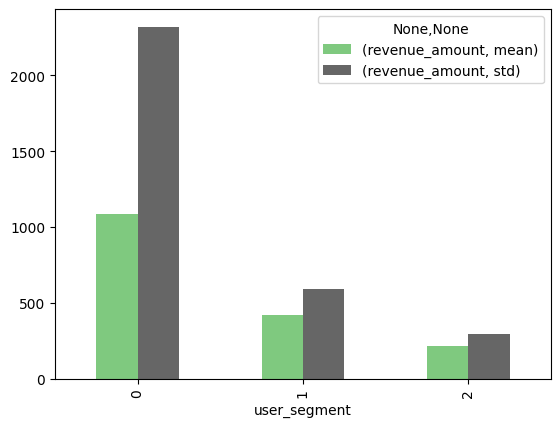

In [169]:
_ = df[['user_segment', 'revenue_amount']].groupby('user_segment').agg(['mean', 'std']).plot( kind='bar', cmap='Accent')

#### Cреднее и дисперсия по category

<AxesSubplot:xlabel='category'>

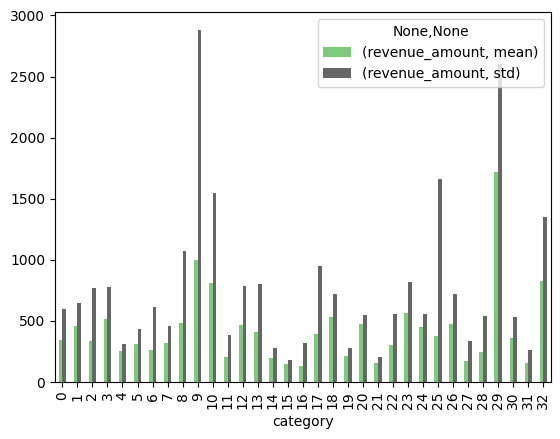

In [10]:
_ = df[['category', 'revenue_amount']].groupby('category').agg(['mean', 'std']).plot( kind='bar', cmap='Accent')

#### Cреднее и дисперсия по region

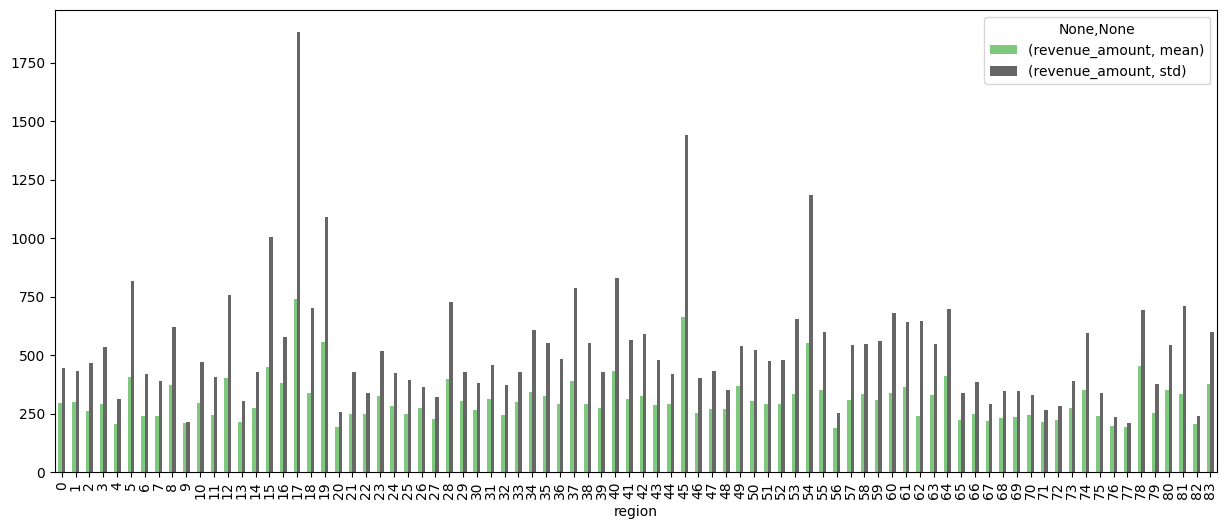

In [172]:
_ = df[['region', 'revenue_amount']].groupby('region').agg(['mean', 'std']).plot( kind='bar', cmap='Accent', figsize=(15, 6))


#### Метрика суммы продаж за день под конец обваливается :/


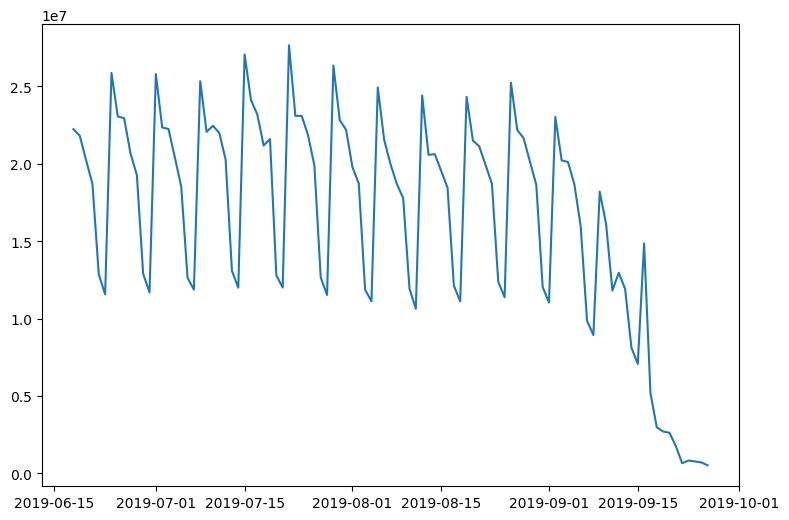

In [44]:
df_by_date = df.groupby('event_date').sum()

plt.figure(figsize=(9, 6))
_ = plt.plot(df.groupby('event_date').sum().index, df.groupby('event_date').sum().revenue_amount)

#### Датасет по 100 дням

In [12]:
df.event_date.min() - df.event_date.max()

Timedelta('-100 days +00:00:00')

In [146]:
df.event_date.min()

Timestamp('2019-06-18 00:00:00')

In [14]:
def choose_date(df, start_date, delta, share): 
    tmp = df[(df.event_date>=start_date)&(df.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp=tmp.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%100<=int(100*share)]
    return x

### MDE размеров тестовых групп 10,25,50% и длительностей 30, 60, 90 дней 

In [173]:
for duration in [30, 60, 90]:
    for share in [0.1, 0.25, 0.5]:

        x1 = choose_date(df, datetime.datetime(2019, 6, 18, 0, 0), duration, share)

        mean = x1.revenue_amount.mean()
        std = x1.revenue_amount.std()

        alpha = 0.01
        power = 0.8

        effect_size = tt_ind_solve_power(nobs1=x1.shape[0], alpha = alpha, power = power, ratio=1.0, alternative='two-sided')
        result_effect = effect_size * std / mean 
        print(f'For duration {duration} and share {share} mde : {result_effect:.2%}')

For duration 30 and share 0.1 mde : 12.78%
For duration 30 and share 0.25 mde : 9.31%
For duration 30 and share 0.5 mde : 5.89%
For duration 60 and share 0.1 mde : 12.70%
For duration 60 and share 0.25 mde : 9.05%
For duration 60 and share 0.5 mde : 5.74%
For duration 90 and share 0.1 mde : 12.42%
For duration 90 and share 0.25 mde : 9.03%
For duration 90 and share 0.5 mde : 5.74%


#### Наименьшие значения в доле 0.5 и длительностей 60 и 90 дней, после 60 дней выходит на плато 

### Описание функции для разбиения датасета и формирования CUPED метрики:
- Выбираем с датасета предпериод и формируем группы пользователей для теста, выбираем период после "тритмента"
- Для выбранных пользоваетелей находим значения метрики после тритмента, если значения нет то проставляем 0, как если бы хотели считать ARPU
- Далее считаем CUPED метрику по выбранному предпериоду 
- Формируем новый датасет и возвращаем его 

In [148]:
def make_df_for_cuped(df, pred_duration, post_duration, share, for_sesoanality):
    pred = choose_date(df, datetime.datetime(2019, 6, 18, 0, 0) + datetime.timedelta(days=for_sesoanality), pred_duration, share)
    post = choose_date(df, datetime.datetime(2019, 6, 18, 0, 0) + datetime.timedelta(days=pred_duration) + datetime.timedelta(days=for_sesoanality), post_duration, share)

    df_for_cuped = pd.merge(pred[['user_id', 'revenue_amount']], post[['user_id', 'revenue_amount']],  how='left', on='user_id')
    df_for_cuped.rename(columns={'revenue_amount_y': 'revenue_amount',
                                 'revenue_amount_x':'revenue_amount_pred'}, inplace=True)
    df_for_cuped.fillna(0, inplace=True)

    theta = np.cov(df_for_cuped['revenue_amount'], df_for_cuped['revenue_amount_pred'], ddof=1)[0,1] / np.var(df_for_cuped['revenue_amount_pred'], ddof=1)
    df_for_cuped['cuped'] = df_for_cuped['revenue_amount'] - theta * (df_for_cuped['revenue_amount_pred'] - df_for_cuped['revenue_amount_pred'].mean())
    
    return df_for_cuped

### Периодичность

#### Здесь берем длиетльность предпериода 30 дней и длительность периода после 30 дней и сравниваю получаемое mde для обычной метрики и CUPED метрики

In [178]:
for weeks_shift in range(1, 6):

    x1 = make_df_for_cuped(df, 30, 30, 0.5, weeks_shift)

    mean_cuped = x1.cuped.mean()
    std_cuped = x1.cuped.std()

    mean_reg = x1.revenue_amount.mean()
    std_reg = x1.revenue_amount.std()
    
    alpha = 0.01
    power = 0.8

    effect_size_cuped = tt_ind_solve_power(nobs1=x1.shape[0], alpha=alpha, power=power, ratio=1.0, alternative='two-sided')
    result_effect_cuped = effect_size_cuped * std_cuped / mean_cuped

    effect_size_reg = tt_ind_solve_power(nobs1=x1.shape[0], alpha=alpha, power=power, ratio=1.0, alternative='two-sided')
    result_effect_reg = effect_size_reg * std_reg / mean_reg


    print(f'For cuped pred_deuration 30 days and week_shift {weeks_shift} mde in %: {result_effect_cuped:.2%}')

    print(f'For reg pred_deuration 30  days and week_shift {weeks_shift} mde in %: {result_effect_reg:.2%}')
    print(f'regular_mde / cuped_mde {(result_effect_reg / result_effect_cuped):.2f} \n')

For cuped pred_deuration 30 days and week_shift 1 mde in %: 4.19%
For reg pred_deuration 30  days and week_shift 1 mde in %: 7.56%
regular_mde / cuped_mde 1.81 

For cuped pred_deuration 30 days and week_shift 2 mde in %: 4.31%
For reg pred_deuration 30  days and week_shift 2 mde in %: 7.52%
regular_mde / cuped_mde 1.75 

For cuped pred_deuration 30 days and week_shift 3 mde in %: 4.31%
For reg pred_deuration 30  days and week_shift 3 mde in %: 7.66%
regular_mde / cuped_mde 1.78 

For cuped pred_deuration 30 days and week_shift 4 mde in %: 4.19%
For reg pred_deuration 30  days and week_shift 4 mde in %: 7.69%
regular_mde / cuped_mde 1.83 

For cuped pred_deuration 30 days and week_shift 5 mde in %: 4.18%
For reg pred_deuration 30  days and week_shift 5 mde in %: 7.71%
regular_mde / cuped_mde 1.84 



#### Видим, что не особо влияет период, который мы выбираем для cuped метрики, как собственно и для обычной метрики  

### Длительность пердпериода

#### Здесь берем длиетльность предпериода 30 дней и варьируем длительность периода после и сравниваю получаемое mde для обычной метрики и CUPED метрики

In [167]:
for pred_deuration in range(1, 8):

    x1 = make_df_for_cuped(df, pred_deuration * 10, 30, 0.5, 0)

    mean_cuped = x1.cuped.mean()
    std_cuped = x1.cuped.std()

    mean_reg = x1.revenue_amount.mean()
    std_reg = x1.revenue_amount.std()
    
    alpha = 0.01
    power = 0.8

    effect_size_cuped = tt_ind_solve_power(nobs1=x1.shape[0], alpha=alpha, power=power, ratio=1.0, alternative='two-sided')
    result_effect_cuped = effect_size_cuped * std_cuped / mean_cuped

    effect_size_reg = tt_ind_solve_power(nobs1=x1.shape[0], alpha=alpha, power=power, ratio=1.0, alternative='two-sided')
    result_effect_reg = effect_size_reg * std_reg / mean_reg


    print(f'For cuped test and pred_deuration {pred_deuration * 10} days mde : {result_effect_cuped:.2%}')

    print(f'For reg test and pred_deuration {pred_deuration * 10} days mde in %: {result_effect_reg:.2%}')
    print(f'regular_mde / cuped_mde {(result_effect_reg / result_effect_cuped):.2f} \n')


For cuped test and pred_deuration 10 days mde : 5.31%
For reg test and pred_deuration 10 days mde in %: 8.25%
regular_mde / cuped_mde 1.55 

For cuped test and pred_deuration 20 days mde : 4.10%
For reg test and pred_deuration 20 days mde in %: 7.54%
regular_mde / cuped_mde 1.84 

For cuped test and pred_deuration 30 days mde : 4.13%
For reg test and pred_deuration 30 days mde in %: 7.59%
regular_mde / cuped_mde 1.84 

For cuped test and pred_deuration 40 days mde : 3.92%
For reg test and pred_deuration 40 days mde in %: 7.67%
regular_mde / cuped_mde 1.96 

For cuped test and pred_deuration 50 days mde : 3.67%
For reg test and pred_deuration 50 days mde in %: 7.80%
regular_mde / cuped_mde 2.13 

For cuped test and pred_deuration 60 days mde : 2.87%
For reg test and pred_deuration 60 days mde in %: 7.23%
regular_mde / cuped_mde 2.52 

For cuped test and pred_deuration 70 days mde : 2.87%
For reg test and pred_deuration 70 days mde in %: 6.95%
regular_mde / cuped_mde 2.42 



#### Видим что mde уменьшается при увеличении предпериода, но это скорее из-за того что берем в тест больше пользователей просто, собственно минимальное mde для предпериода в 70 дней